In [2]:
#importing all the libraries 
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning libraries  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import sklearn.metrics as metrics
import xgboost as xgb

# Machine Learning Part of B2B Order Management Application 


Through this model we have tried to predict the date of payment and aging bucket of an invoice from the invoice creation. The whole purpose of the model is to help the account receivel team in the payment processs from the past Experiences 
<br>
<br>
Similar to any machine learning project it is a kind of supervised probelm and we have applied regression for the purpose
<br>
Here is the Workflow of the Whole Process.
<br> 
<a id='starting'></a>
1. [Dataset](#dataset) 
2. [Preprocessing](#preprocessing) 
3. [EDA and Data Visualization](#eda)
4. [Feature Selection](#featureselection)
5. [Machine Learning Algorithms](#ml)
6. [Hyperparameters tunning](#Hyper) 
7. [Model Selection](#model)
8. [Mapping](#Mapping) 

![title](flow.png)

<a id='dataset'></a>
# <b>1.Dataset</b> 

### <b> Observation</b>

* There is a Duplicate available in dataset named 'document_create_date.1' 
* There is also rows available in the dataset that is missing large number of value i.e clear_date,area_business so we dropped these rows
* Two more thing thing that is noticeable  is <b> date and Currency </b> is not in well formeted 
* Most important we have also found ou the target variablle that is delay in dates for the invoice that is Generated

* Go to [Flowchart](#starting)

In [3]:
def load_data(notebook_name):
    " should be working in the same path "
    import os
    path= os.getcwd()
    print("currently working in "+ str(os.listdir()))
    path= os.getcwd()
    data = pd.read_csv(os.getcwd()+"//"+notebook_name)
    df = pd.DataFrame(data)
    return data


In [4]:
df = load_data("data.csv") 

df.columns

currently working in ['.ipynb_checkpoints', '.vscode', 'data.csv', 'experiment.csv', 'flow.png', 'Invoice management system.ipynb', 'ml_copy-Copy1.ipynb', 'Modeling_assignment.ipynb', 'my_work.ipynb', 'rough.ipynb']


Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [5]:
df.shape

(50000, 19)

In [6]:
## Duplicates
df_1 = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_1.isna().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date              10000
buisness_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
invoice_currency            0
document type               0
posting_id                  0
area_business           50000
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
invoice_id                  6
isOpen                      0
dtype: int64

In [7]:
#area has overall all the null value hence dropping 
df_1 = df_1.drop(['area_business'], axis = 1)

#similar to tarea buisenss clear date is having atmost to many null  value 
# but it is essential for finding targer payment 
# hence we are dropping only null value 
df_1 = df_1.dropna(axis = 0, how ='any')
df_1.shape


(39994, 17)

In [8]:
df_1.isna().sum()

business_code           0
cust_number             0
name_customer           0
clear_date              0
buisness_year           0
doc_id                  0
posting_date            0
document_create_date    0
due_in_date             0
invoice_currency        0
document type           0
posting_id              0
total_open_amount       0
baseline_create_date    0
cust_payment_terms      0
invoice_id              0
isOpen                  0
dtype: int64

In [9]:
df_1[:10]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200210.0,USD,RV,1.0,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190811.0,USD,RV,1.0,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190929.0,USD,RV,1.0,2253.86,20190914.0,NAA8,1.929874e+09,0
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191128.0,USD,RV,1.0,33133.29,20191113.0,NAH4,1.930148e+09,0
5,CA02,0140106181,THE corporation,2019-12-04 00:00:00,2019.0,2.960581e+09,2019-09-20,20190920,20191004.0,CAD,RV,1.0,22225.84,20190924.0,CA10,2.960581e+09,0
6,U001,0200769623,WAL-MAR in,2019-11-12 00:00:00,2019.0,1.930083e+09,2019-11-01,20191031,20191116.0,USD,RV,1.0,7358.49,20191101.0,NAH4,1.930083e+09,0
8,U001,0200769623,WAL-MAR corp,2019-06-18 00:00:00,2019.0,1.929440e+09,2019-06-07,20190605,20190622.0,USD,RV,1.0,15995.04,20190607.0,NAH4,1.929440e+09,0
9,U001,0200762301,C&S WH systems,2019-03-06 00:00:00,2019.0,1.928819e+09,2019-02-20,20190219,20190307.0,USD,RV,1.0,28.63,20190220.0,NAC6,1.928819e+09,0
11,U001,0200743129,BROOKS co,2019-01-22 00:00:00,2019.0,1.928551e+09,2019-01-02,20190102,20190117.0,USD,RV,1.0,103147.37,20190102.0,NAA8,1.928551e+09,0
12,U001,0200186937,SYSC corporation,2019-05-06 00:00:00,2019.0,1.929152e+09,2019-04-15,20190415,20190430.0,USD,RV,1.0,16381.45,20190415.0,NAA8,1.929152e+09,0


<a id='preprocessing'></a>
# <b> 2.  Preprocessing </b>

* In preprocessing we have done some simple steps like 
data cleaning, data integration, data reduction, and data transformation

    1.  converting cad amount into usd 
    2.  formetting date into proper formet 
    3.  then we created train and test with making target column
        * for <b> target variable </b> we have just subtracted clear_date with due_date 

## 2.1 remember to convert amount into usd  

In [10]:
currecy = (df["invoice_currency"])

usd,cad = 0,0
for i in range(len(currecy)):
    if(currecy[i]=="USD"):
        usd+=1
    elif(currecy[i]=="CAD"):
        cad +=1 
print(usd,cad)      
        

46081 3919


## 2.2 Formatting Date 

In [11]:
def change_date(x_type):
    x = int(x_type)
    x = str(x)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [12]:
print(type(change_date(20200210.0)))
print(change_date(20200210.0))

<class 'datetime.datetime'>
2020-02-10 00:00:00


 ## 2.3 Creating Target Varible 

In [13]:
df_1['due_date'] = df_1['due_in_date'].apply(change_date)
df_1['clear_date']= pd.to_datetime(df_1['clear_date']) 

# target variable
df_1['target'] = (df_1['clear_date'] - df_1['due_date']).dt.days

In [14]:
## just applied in the proper formet

df_1['document_create_date'] = df_1['document_create_date'].apply(change_date)
df_1['baseline_create_date'] = df_1['baseline_create_date'].apply(change_date)
df_1['due_in_date'] = df_1["due_in_date"].apply(change_date)

### The Positive value means that there is delay in payment and negation means it is paid 

In [15]:
df_1["target"][:10]

0      1
1     -3
2     92
4     -3
5     61
6     -4
8     -4
9     -1
11     5
12     6
Name: target, dtype: int64

In [16]:
df_1[:5]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-02-10,USD,RV,1.0,54273.28,2020-01-26,NAH4,1.930438e+09,0,2020-02-10,1
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,USD,RV,1.0,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,USD,RV,1.0,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,USD,RV,1.0,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,CAD,RV,1.0,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61


In [17]:
# Splitting the initial dataframe into train and test
# So in this case we can consider last 3 months for test set.
x_train = df_1[df_1['document_create_date'] <= '2020-01-01'].copy()
x_test = df_1[df_1['document_create_date'] > '2020-01-01'].copy()

In [18]:
x_test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-02-10,USD,RV,1.0,54273.28,2020-01-26,NAH4,1.930438e+09,0,2020-02-10,1
19,U001,0200769623,WAL-MAR systems,2020-02-05,2020.0,1.930438e+09,2020-01-24,2020-01-24,2020-02-08,USD,RV,1.0,53349.54,2020-01-24,NAH4,1.930438e+09,0,2020-02-08,-3
20,U013,0100053554,SYSTEMS systems,2020-02-11,2020.0,1.991838e+09,2020-01-11,2020-01-07,2020-02-10,USD,RV,1.0,5683.50,2020-01-11,NAVE,1.991838e+09,0,2020-02-10,1
24,U001,0200769623,WAL-MAR co,2020-02-04,2020.0,1.930431e+09,2020-01-24,2020-01-23,2020-02-08,USD,RV,1.0,11307.78,2020-01-24,NAH4,1.930431e+09,0,2020-02-08,-4
41,U001,0200769623,WAL-MAR associates,2020-01-21,2020.0,1.930353e+09,2020-01-04,2020-01-04,2020-01-19,USD,RV,1.0,4953.83,2020-01-04,NAH4,1.930353e+09,0,2020-01-19,2


In [19]:
print(x_train.shape)
print(x_test.shape)

(34971, 19)
(5023, 19)


<a id='eda'></a>
# <b> 3. EDA </b> 
<br> 

* Through EDA We want to just watch certain data and see how our data is distributed
        1. First we want to look how how our buiseness are doing
        2. Invoice Currency 
        3. Payment is Done or Not 
        4. Document Type 
        5. Posting Id 
        6. Customer Payment Terms 
        7. 
* Go to [Flowchart](#starting)

## 3.1  Buisness Columns 


In [20]:
print(dict(x_train['business_code'].value_counts()))
print(dict(x_test['business_code'].value_counts()))

{'U001': 31589, 'CA02': 2820, 'U013': 442, 'U002': 107, 'U005': 9, 'U007': 4}
{'U001': 4601, 'CA02': 354, 'U013': 59, 'U002': 9}


<AxesSubplot:xlabel='business_code', ylabel='count'>

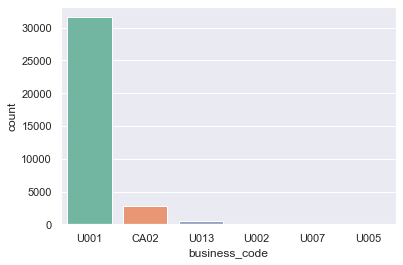

In [21]:
sns.set(style ="darkgrid")
sns.countplot(x = x_train['business_code'], palette = "Set2")

<AxesSubplot:xlabel='business_code', ylabel='count'>

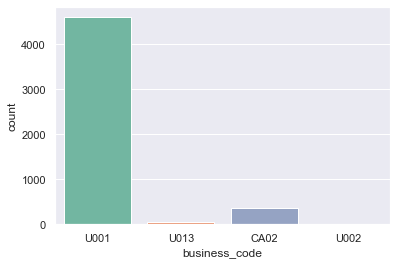

In [22]:
sns.countplot(x = x_test['business_code'], palette = "Set2")

## 3.2 Invoice Currency 

In [23]:
print(dict(x_train['invoice_currency'].value_counts()))
print(dict(x_test['invoice_currency'].value_counts()))

{'USD': 32149, 'CAD': 2822}
{'USD': 4669, 'CAD': 354}


<AxesSubplot:xlabel='invoice_currency', ylabel='count'>

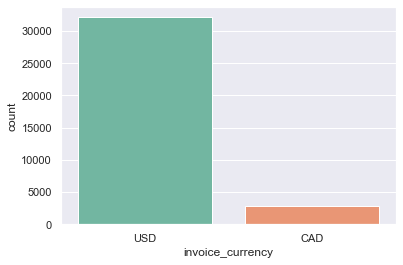

In [24]:
sns.countplot(x = x_train['invoice_currency'], palette = "Set2")

<AxesSubplot:xlabel='invoice_currency', ylabel='count'>

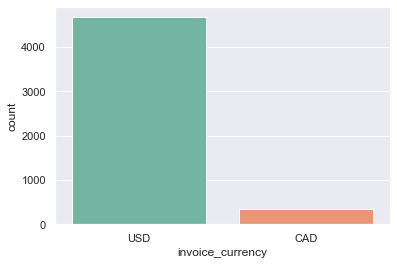

In [25]:
sns.countplot(x =x_test['invoice_currency'], palette = "Set2")

## 3.3 payment Related Observation


In [26]:
print(dict(x_train['isOpen'].value_counts()))
print(dict(x_test['isOpen'].value_counts()))

{0: 34971}
{0: 5023}


In [27]:
clearPayment_month= x_train.clear_date.dt.month
clearPayment_week= x_train.clear_date.dt.week

clearPayment_month.value_counts().sort_values(axis = 0)

C:\Users\karti\AppData\Local\Temp\ipykernel_15484\2770081958.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  clearPayment_week= x_train.clear_date.dt.week


1     1587
2     2487
6     2803
9     2920
3     2962
7     3087
8     3103
11    3118
10    3144
12    3179
4     3191
5     3390
Name: clear_date, dtype: int64

<AxesSubplot:xlabel='clear_date', ylabel='count'>

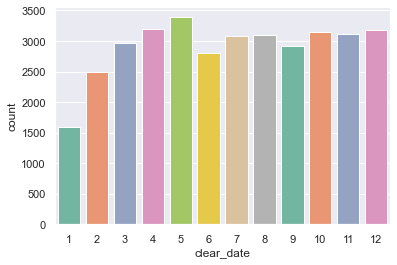

In [32]:
# jsut a simple visualization
sns.countplot(x= clearPayment_month,palette = "Set2")

In [28]:
clearPayment_week.value_counts().sort_index()
# observe that the first is 

1     322
2     125
3     501
4     493
5     603
6     593
7     691
8     608
9     656
10    643
11    632
12    716
13    774
14    700
15    725
16    718
17    718
18    814
19    724
20    690
21    739
22    754
23    675
24    689
25    674
26    764
27    703
28    727
29    601
30    673
31    739
32    650
33    688
34    616
35    793
36    614
37    733
38    652
39    754
40    669
41    714
42    658
43    699
44    814
45    691
46    682
47    721
48    781
49    709
50    620
51    793
52    736
Name: clear_date, dtype: int64

<AxesSubplot:xlabel='clear_date', ylabel='count'>

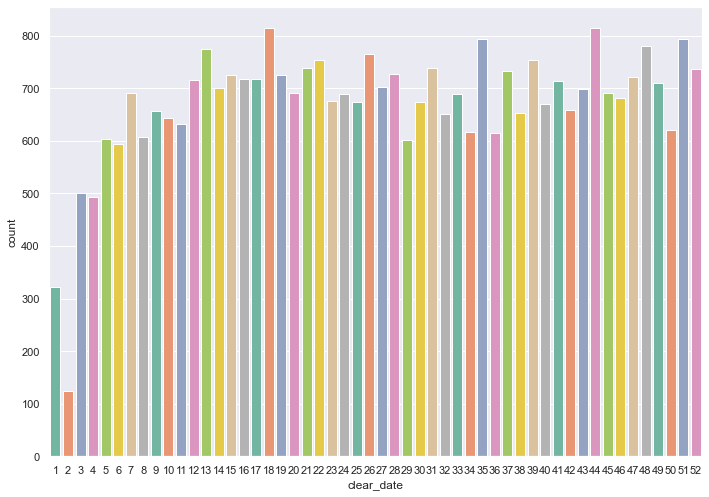

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x= clearPayment_week,palette = "Set2")

## 3.4 Document Types 

In [197]:
print(dict(x_train['document type'].value_counts()))
print(dict(x_test['document type'].value_counts()))

{'RV': 34971}
{'RV': 5023}


## 3.5 Customer Payment Terms 

## <b> Observation</b> 
    * There are two many category hence we really need to find a way to group these element 
    * if we want to include in the features 
    * or other option is to drop it completely 

In [198]:
print(dict(x_train['cust_payment_terms'].value_counts()))
print("Testing Data")
print(dict(x_test['cust_payment_terms'].value_counts()))

{'NAA8': 14032, 'NAH4': 9267, 'CA10': 2727, 'NAC6': 1167, 'NAM4': 947, 'NAAX': 836, 'NAD1': 719, 'NAU5': 633, 'NAG2': 623, 'NAGD': 527, 'NA32': 526, 'NAX2': 469, 'NAM2': 418, 'NA10': 310, 'NAD5': 239, 'NAM1': 191, 'NAVE': 189, 'NAVF': 183, 'NAAW': 138, 'NAWU': 117, 'NAWN': 97, 'NAVR': 84, 'NAVQ': 75, 'NAWP': 48, 'CA30': 40, 'NAUZ': 37, 'NA3B': 36, 'NAVM': 31, 'NACB': 28, 'NA38': 23, 'NABG': 19, 'NAD4': 19, 'NAB1': 16, 'NAVD': 13, 'C106': 12, 'NA84': 12, 'NAVL': 11, 'BR56': 10, 'NAUP': 10, 'NA9X': 10, 'NA3F': 8, 'NATM': 7, 'NAM3': 6, 'CAB1': 6, 'CAX2': 5, 'NATJ': 5, 'NA25': 4, 'NAWM': 4, 'NATW': 4, 'B052': 3, 'NATH': 3, 'NAVC': 3, 'NA8Q': 3, 'NATL': 2, 'NAV9': 2, 'NATX': 2, '90M7': 2, 'NA31': 2, 'NATU': 1, 'NATK': 1, 'CA60': 1, 'NAUY': 1, 'NAUW': 1, 'NABD': 1, 'NATV': 1, 'MC15': 1, 'NAD8': 1, 'NAV2': 1, 'BR12': 1}
Testing Data
{'NAA8': 1984, 'NAH4': 1326, 'CA10': 342, 'NAM4': 165, 'NAC6': 150, 'NAAX': 126, 'NAGD': 119, 'NAG2': 100, 'NAD1': 100, 'NA32': 81, 'NAX2': 79, 'NAM2': 71, 'NAU5'

In [85]:
#countplot is not possible because of the avalibility of the data
#just for the plot 
import random
random1 =x_train['cust_payment_terms'].value_counts()
print(random1[:10])
#x_train = sort(x_train)
sorted_random =({k: v for k, v in sorted(random1.items(), key=lambda item: item[1])})


NAA8    14032
NAH4     9267
CA10     2727
NAC6     1167
NAM4      947
NAAX      836
NAD1      719
NAU5      633
NAG2      623
NAGD      527
Name: cust_payment_terms, dtype: int64


In [122]:
data_items =sorted_random.items()
data_list = list(data_items)
dfxc = pd.DataFrame(data_list)
dfxc.columns = (['Name', 'Values'])
dfxc = dfxc.sort_values(by =["Values"])
y_pos =  np.arange(len(dfxc["Name"]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    69 non-null     object
 1   Values  69 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


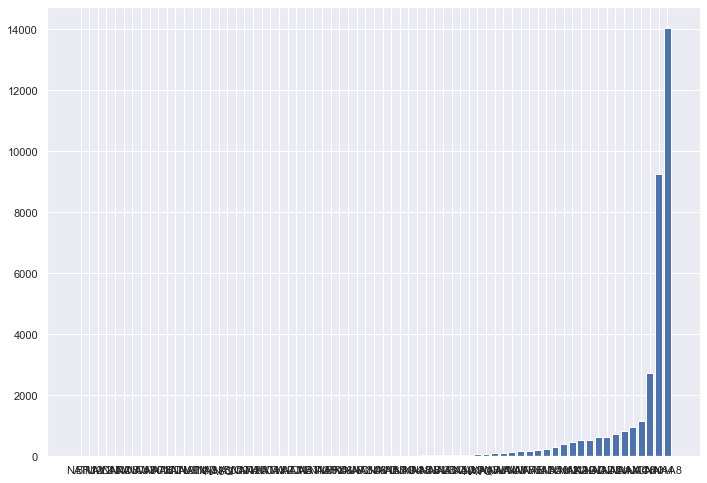

In [124]:
dfxc.info()
plt.bar(y_pos, dfxc["Values"])
plt.xticks(y_pos,dfxc["Name"]) 
plt.show()

## 3.6 Posting ID 

# 4 Feature Selection

In [200]:
# First We will be starting with the dropping the different values that is not useful 
## that is 
x_train.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,USD,RV,1.0,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,USD,RV,1.0,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,USD,RV,1.0,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,CAD,RV,1.0,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-16,USD,RV,1.0,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


In [201]:
## Dropping the Column [Posting_ID , is_open, Document_type] since they are only one value 
x_train =  x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
x_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

In [202]:
x_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,USD,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,USD,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,USD,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,CAD,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-16,USD,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


In [203]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         34971 non-null  object        
 1   cust_number           34971 non-null  object        
 2   name_customer         34971 non-null  object        
 3   clear_date            34971 non-null  datetime64[ns]
 4   buisness_year         34971 non-null  float64       
 5   doc_id                34971 non-null  float64       
 6   posting_date          34971 non-null  object        
 7   document_create_date  34971 non-null  datetime64[ns]
 8   due_in_date           34971 non-null  datetime64[ns]
 9   invoice_currency      34971 non-null  object        
 10  total_open_amount     34971 non-null  float64       
 11  baseline_create_date  34971 non-null  datetime64[ns]
 12  cust_payment_terms    34971 non-null  object        
 13  invoice_id      

In [204]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5023 entries, 0 to 49997
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         5023 non-null   object        
 1   cust_number           5023 non-null   object        
 2   name_customer         5023 non-null   object        
 3   clear_date            5023 non-null   datetime64[ns]
 4   buisness_year         5023 non-null   float64       
 5   doc_id                5023 non-null   float64       
 6   posting_date          5023 non-null   object        
 7   document_create_date  5023 non-null   datetime64[ns]
 8   due_in_date           5023 non-null   datetime64[ns]
 9   invoice_currency      5023 non-null   object        
 10  total_open_amount     5023 non-null   float64       
 11  baseline_create_date  5023 non-null   datetime64[ns]
 12  cust_payment_terms    5023 non-null   object        
 13  invoice_id       

## 4.1 Dealing With Date Formet
    * WE are gonna create a day and month from the Date Creating Column 
    


In [205]:
x_train["doc_create_day"] = x_train["document_create_date"].dt.day
x_train["doc_create_month"] = x_train["document_create_date"].dt.month

In [206]:
x_train["due_day"] =  x_train["due_in_date"].dt.day
x_train["due_month"] = x_train["due_in_date"].dt.month

In [207]:
x_test["doc_create_day"] = x_test["document_create_date"].dt.day
x_test["doc_create_month"] = x_test["document_create_date"].dt.month
x_test["due_day"] =  x_test["due_in_date"].dt.day
x_test["due_month"] = x_test["due_in_date"].dt.month

In [208]:
x_train = x_train

In [209]:
x_test = x_test

## 4.2 Dealing with Currency 

In [210]:
x_train['invoice_currency'] = x_train['invoice_currency'].map({'USD': 0,'CAD': 1})
x_test['invoice_currency'] = x_test['invoice_currency'].map({'USD': 0,'CAD': 1})

In [211]:
x_train

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,...,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target,doc_create_day,doc_create_month,due_day,due_month
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,0,...,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3,22,7,11,8
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,0,...,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92,14,9,29,9
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,0,...,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3,13,11,28,11
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,1,...,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61,20,9,4,10
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-16,0,...,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4,31,10,16,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49991,U001,0200704045,RA trust,2019-10-25,2019.0,1.930001e+09,2019-10-10,2019-10-11,2019-10-25,0,...,2019-10-10,NAA8,1.930001e+09,0,2019-10-25,0,11,10,25,10
49994,U001,0200762301,C&S WH trust,2019-07-25,2019.0,1.929601e+09,2019-07-10,2019-07-09,2019-07-25,0,...,2019-07-10,NAC6,1.929601e+09,0,2019-07-25,0,9,7,25,7
49996,U001,0200769623,WAL-MAR co,2019-09-03,2019.0,1.929744e+09,2019-08-15,2019-08-14,2019-08-30,0,...,2019-08-15,NAH4,1.929744e+09,0,2019-08-30,4,14,8,30,8
49998,U001,0200726979,BJ'S llc,2019-12-12,2019.0,1.930199e+09,2019-11-27,2019-11-26,2019-12-12,0,...,2019-11-27,NAA8,1.930199e+09,0,2019-12-12,0,26,11,12,12


## 4.3 Dealing with the Name_customer and Cust_payment_terms 

In [212]:
# too much of classes hence not a option to include in the model as it will make it complicated 
# we will drop it later on 
x_train["name_customer"].value_counts()

WAL-MAR trust          821
WAL-MAR in             790
WAL-MAR                785
WAL-MAR corp           783
WAL-MAR corporation    773
                      ... 
SING associates          1
LAWR corporation         1
GEOR co                  1
COS in                   1
FOOD S                   1
Name: name_customer, Length: 3647, dtype: int64

In [213]:
x_train["cust_payment_terms"].value_counts()

NAA8    14032
NAH4     9267
CA10     2727
NAC6     1167
NAM4      947
        ...  
NATV        1
MC15        1
NAD8        1
NAV2        1
BR12        1
Name: cust_payment_terms, Length: 69, dtype: int64

In [214]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5023 entries, 0 to 49997
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         5023 non-null   object        
 1   cust_number           5023 non-null   object        
 2   name_customer         5023 non-null   object        
 3   clear_date            5023 non-null   datetime64[ns]
 4   buisness_year         5023 non-null   float64       
 5   doc_id                5023 non-null   float64       
 6   posting_date          5023 non-null   object        
 7   document_create_date  5023 non-null   datetime64[ns]
 8   due_in_date           5023 non-null   datetime64[ns]
 9   invoice_currency      5023 non-null   int64         
 10  total_open_amount     5023 non-null   float64       
 11  baseline_create_date  5023 non-null   datetime64[ns]
 12  cust_payment_terms    5023 non-null   object        
 13  invoice_id       

In [215]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         34971 non-null  object        
 1   cust_number           34971 non-null  object        
 2   name_customer         34971 non-null  object        
 3   clear_date            34971 non-null  datetime64[ns]
 4   buisness_year         34971 non-null  float64       
 5   doc_id                34971 non-null  float64       
 6   posting_date          34971 non-null  object        
 7   document_create_date  34971 non-null  datetime64[ns]
 8   due_in_date           34971 non-null  datetime64[ns]
 9   invoice_currency      34971 non-null  int64         
 10  total_open_amount     34971 non-null  float64       
 11  baseline_create_date  34971 non-null  datetime64[ns]
 12  cust_payment_terms    34971 non-null  object        
 13  invoice_id      

In [216]:
# dropping all the unrequired featured 

x_train_final = x_train.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date', "due_in_date"], axis = 1)

In [217]:
x_test_final = x_test.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date',"due_in_date"], axis = 1)

In [218]:
x_train_final["customer_number"] = x_train_final['cust_number'].str.extract('(\d+)')
x_train_final=x_train_final.drop(columns= ["cust_number"])

In [219]:
x_test_final["customer_number"] = x_test_final['cust_number'].str.extract('(\d+)')
x_test_final = x_test_final.drop(columns= ["cust_number"])

In [220]:
x_test_final

,buisness_year,invoice_currency,total_open_amount,isOpen,target,doc_create_day,doc_create_month,due_day,due_month,customer_number
0,2020.0,0,54273.28,0,1,25,1,10,2,0200769623
19,2020.0,0,53349.54,0,-3,24,1,8,2,0200769623
20,2020.0,0,5683.50,0,1,7,1,10,2,0100053554
24,2020.0,0,11307.78,0,-4,23,1,8,2,0200769623
41,2020.0,0,4953.83,0,2,4,1,19,1,0200769623
...,...,...,...,...,...,...,...,...,...,...
49955,2020.0,1,1082.69,0,13,28,1,8,2,0140106408
49957,2020.0,0,348.35,0,0,4,2,18,2,0200726979
49989,2020.0,0,33729.79,0,1,19,2,4,3,0200772670
49993,2020.0,0,31.62,0,62,8,1,23,1,0200726979


## 4.10 Splitting the Final Data 


In [221]:
y_train_final1 =  x_train_final["target"]
x_train_final1 = x_train_final.drop(["target"],axis =1) 

In [222]:
print(y_train_final1.info())
print(x_train_final1.info())

<class 'pandas.core.series.Series'>
Int64Index: 34971 entries, 1 to 49999
Series name: target
Non-Null Count  Dtype
--------------  -----
34971 non-null  int64
dtypes: int64(1)
memory usage: 546.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   buisness_year      34971 non-null  float64
 1   invoice_currency   34971 non-null  int64  
 2   total_open_amount  34971 non-null  float64
 3   isOpen             34971 non-null  int64  
 4   doc_create_day     34971 non-null  int64  
 5   doc_create_month   34971 non-null  int64  
 6   due_day            34971 non-null  int64  
 7   due_month          34971 non-null  int64  
 8   customer_number    34971 non-null  object 
dtypes: float64(2), int64(6), object(1)
memory usage: 2.7+ MB
None


In [223]:
Xtrain ,Xtest, ytrain, ytest = train_test_split(x_train_final1, y_train_final1, test_size = 0.3, random_state=0)

   ## 5 ML MODEL
   
        1.  Linear Regression
        2.  Support Vector Regression
        3.  Decision Tree Regression
        4.  Random Forest Regressor 
 

In [270]:
MSE_Score = []
R2_Score = []
Algorithm = []

### <b>5.1 Linear Regreesion </b>

In [271]:
Algorithm.append('Linear Regression')
model = LinearRegression()
model.fit(Xtrain, ytrain)
predicted =model.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b>5.2 Random Forest Regression </b>

In [272]:
Algorithm.append('Random Forest Regression')
model1 = RandomForestRegressor()
model1.fit(Xtrain, ytrain)
predicted =model1.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b> 5.3 Support Vector Regression</b>

In [273]:
Algorithm.append('Support Vector Regression')
model2 = SVR()
model2.fit(Xtrain, ytrain)
predicted =model2.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b> 5.4 Decision Tree Regressor</b>

In [274]:
Algorithm.append('Decision Tree Regressor')
model3 = DecisionTreeRegressor()
model3.fit(Xtrain, ytrain)
predicted =model3.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

In [275]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])

In [276]:
Comparison

,Algorithm,MSE_Score,R2_Score
0,Linear Regression,91.237682,0.157340
1,Random Forest Regression,62.638028,0.421483
2,Support Vector Regression,90.692141,0.162379
3,Decision Tree Regressor,121.254848,-0.119895
